# Train classfier
Build and save a classifier to discriminate true citation sentences (target - binary) given a set of input features (binary, count)

Goals:
- we want high recall first in this step (classifier should predict as many true citation sentences as possible)
- then we want precision (NER will help us identify the right portion of the citation sentence to submit)

Resources:
- [Fitting models on imbalanced data](https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html)
- [Comparing Random Forest (RF) and Logistic Regression (LR)](https://medium.com/@bemali_61284/random-forest-vs-logistic-regression-16c0c8e2484c)

In [1]:
import re
import pandas as pd
import numpy as np
import pickle
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
def clean_text(txt):
    """
    Convert to lowercase, remove special characters, and punctuation.
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def find_acronyms(txt):
    """
    finds and returns a sequence of capital letters
    for use on dataset_titles, dataset_labels, or full text
    """
    matches = re.findall(r"\b[A-Z\.]{2,}s?\b", txt)
    if matches:
        return 1
    else:
        return 0

def count_acronyms(txt):
    """
    finds and returns a sequence of capital letters
    for use on dataset_titles, dataset_labels, or full text
    """
    matches = re.findall(r"\b[A-Z\.]{2,}s?\b", txt)
    if matches:
        return len(matches)
    else:
        return 0

In [3]:
# DATA_DIR = '/nfs/turbo/hrg/bib/icpsr-we-have-the-data/'
# DATA_DIR = '/nfs/turbo/hrg/coleridge/'

## Load and prepare data

In [4]:
# df = pd.read_csv(DATA_DIR+'train_sents_all.csv', index_col=0)

# df['hasICPSRTitle'] = df['hasICPSRTitle'].astype('category').cat.codes
# df['hasDATAGOVTitle'] = df['hasDATAGOVTitle'].astype('category').cat.codes
# df['Match'] = df['match'].astype('category').cat.codes

# df = df.drop(columns=['Id',
#                       'dataset_label', 
#                       'section_title', 
#                       'sent',
#                       'match',
#                       'sent_clean', 
#                       'section_clean'])



# df.Match.value_counts()

In [5]:
df = pd.read_csv('/Users/slafia/Documents/coleridge-kaggle/data/ner_annotate.csv')
df = df[((df['labeler_1']=="Sara"))]

df = df.filter(['paper_section','sentence_text','text_referencing_dataset_1'], axis=1)

# df = df.drop(columns=['paper_id',
#                       'paper_title', 
#                       'source',
#                       'sentence_id',
#                       'labeler_1', 
#                       'contains_dataset_1',
#                       'notes_1', 
#                       'text_referencing_dataset_2', 
#                       'labeler_2', 
#                       'contains_dataset_2', 
#                       'notes_2'])

df['paper_section'] = df['paper_section'].astype(str)
df['sentence_text'] = df['sentence_text'].astype(str)
df['paper_section'] = df['paper_section'].astype(str)

df

,paper_section,sentence_text,text_referencing_dataset_1
0,Results,After examining the effect of switching field ...,none
1,Policy implications: Economic and social policies,These programs help ensure that children do no...,none
2,Special Attention to Inclusion of the SBE Scie...,Program Directors in EHR and SBE are at the fo...,none
3,Clinical variables,Categorical fluency (animals) [23] is a test o...,none
4,a. Observed analysis for the extremely active ...,"Moreover, mean midlevel relative humidity was ...",none
...,...,...,...
2051,Sample,We relied on specific questions within the LEM...,LEMAS-BWCS
2052,Discussion,What is perhaps most striking from the descrip...,ECLS-K
2053,Discussion,"This certainly creates some issues, including ...",UCR
2054,"A. Data on Crime, Social Connectedness, and Co...",UCR data contain monthly counts of the number ...,UCR


## Features

Term frequency, article section, and acronyms

In [6]:
%%time

df['sentence_text_clean'] = df['sentence_text'].apply(clean_text)
df['paper_section_clean']= df['paper_section'].apply(clean_text)

df['hasData'] = np.where(df['sentence_text_clean'].str.contains('data'), 1, 0)
df['hasEdu'] = np.where(df['sentence_text_clean'].str.contains('edu'), 1, 0)
df['hasSample'] = np.where(df['sentence_text_clean'].str.contains('sample'), 1, 0)
df['hasNational'] = np.where(df['sentence_text_clean'].str.contains('national'), 1, 0)
df['hasSurvey'] = np.where(df['sentence_text_clean'].str.contains('survey'), 1, 0)
df['hasPublic'] = np.where(df['sentence_text_clean'].str.contains('public'), 1, 0)
df['hasAvailab'] = np.where(df['sentence_text_clean'].str.contains('availab'), 1, 0)
df['hasNSF'] = np.where(df['sentence_text_clean'].str.contains('nsf'), 1, 0)
df['hasGov'] = np.where(df['sentence_text_clean'].str.contains('gov'), 1, 0)
df['hasAccess'] = np.where(df['sentence_text_clean'].str.contains('access'), 1, 0)
df['hasSupplem'] = np.where(df['sentence_text_clean'].str.contains('supplem'), 1, 0)
df['hasStudy'] = np.where(df['sentence_text_clean'].str.contains('study'), 1, 0)
df['hasReport'] = np.where(df['sentence_text_clean'].str.contains('report'), 1, 0)
df['hasParticip'] = np.where(df['sentence_text_clean'].str.contains('particip'), 1, 0)
df['hasUsed'] = np.where(df['sentence_text_clean'].str.contains('used'), 1, 0)
df['hasUsing'] = np.where(df['sentence_text_clean'].str.contains('using'), 1, 0)
df['hasBased'] = np.where(df['sentence_text_clean'].str.contains('based'), 1, 0)
df['hasAgenc'] = np.where(df['sentence_text_clean'].str.contains('agenc'), 1, 0)
df['hasStatistic'] = np.where(df['sentence_text_clean'].str.contains('statistic'), 1, 0)
df['hasMeasur'] = np.where(df['sentence_text_clean'].str.contains('measur'), 1, 0)

df['inDisc'] = np.where(df['paper_section_clean'].str.contains('disc'), 1, 0)
df['inData'] = np.where(df['paper_section_clean'].str.contains('data'), 1, 0)
df['inSamp'] = np.where(df['paper_section_clean'].str.contains('sampl'), 1, 0)
df['inMeas'] = np.where(df['paper_section_clean'].str.contains('meas'), 1, 0)
df['inMeth'] = np.where(df['paper_section_clean'].str.contains('meth'), 1, 0)
df['inVari'] = np.where(df['paper_section_clean'].str.contains('vari'), 1, 0)
df['inIntr'] = np.where(df['paper_section_clean'].str.contains('intr'), 1, 0)
df['inLimi'] = np.where(df['paper_section_clean'].str.contains('limi'), 1, 0)
df['inAnal'] = np.where(df['paper_section_clean'].str.contains('anal'), 1, 0)
df['inResu'] = np.where(df['paper_section_clean'].str.contains('resu'), 1, 0)

df['hasAcronym'] = df['sentence_text'].apply(find_acronyms)

df['match'] = df.apply(lambda x: x.text_referencing_dataset_1 in x.sentence_text, axis=1)

df = df.drop(columns=['text_referencing_dataset_1'])

df.sample(n=10)

CPU times: user 43.8 ms, sys: 3.89 ms, total: 47.7 ms
Wall time: 44.9 ms


,paper_section,sentence_text,sentence_text_clean,paper_section_clean,hasData,hasEdu,hasSample,hasNational,hasSurvey,hasPublic,...,inSamp,inMeas,inMeth,inVari,inIntr,inLimi,inAnal,inResu,hasAcronym,match
1929,Methods,A secondary analysis using de-identified WRS d...,a secondary analysis using de identified wrs d...,methods,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,False
1937,Analytic Strategies,Since the assignment to the two treatment cond...,since the assignment to the two treatment cond...,analytic strategies,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,True
197,Current Federal Loan Information,Analysts should be aware that the entity grant...,analysts should be aware that the entity grant...,current federal loan information,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
2018,Conclusion,"Once disaggregated, NCVS data show distinct pa...",once disaggregated ncvs data show distinct pat...,conclusion,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
1987,Control variables,"Therefore, we control for the county-level cri...",therefore we control for the county level crim...,control variables,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,True
74,Conclusions and discussion,2010; Murakami et al.,2010 murakami et al,conclusions and discussion,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
2041,The Monitoring the Future Study.,"Unlike the CDC question, the Monitoring the Fu...",unlike the cdc question the monitoring the fut...,the monitoring the future study,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
1934,Probability of Arrest: Consumers and Dealers,The numerator for the probability of arrest fo...,the numerator for the probability of arrest fo...,probability of arrest consumers and dealers,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True
130,"Neuroimaging modalities, including Magnetic Re...",Patch extraction is relatively easy to carry o...,patch extraction is relatively easy to carry o...,neuroimaging modalities including magnetic res...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
2036,Limitations,Although many covariates were considered in th...,although many covariates were considered in th...,limitations,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,True


## Feature selection
21 features

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 0 to 2055
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_section        402 non-null    object
 1   sentence_text        402 non-null    object
 2   sentence_text_clean  402 non-null    object
 3   paper_section_clean  402 non-null    object
 4   hasData              402 non-null    int64 
 5   hasEdu               402 non-null    int64 
 6   hasSample            402 non-null    int64 
 7   hasNational          402 non-null    int64 
 8   hasSurvey            402 non-null    int64 
 9   hasPublic            402 non-null    int64 
 10  hasAvailab           402 non-null    int64 
 11  hasNSF               402 non-null    int64 
 12  hasGov               402 non-null    int64 
 13  hasAccess            402 non-null    int64 
 14  hasSupplem           402 non-null    int64 
 15  hasStudy             402 non-null    int64 
 16  hasRepo

### Binary features only

In [8]:
# df.drop(list(df.filter(regex = 'freq')), axis = 1, inplace = True)
# df.info()

### Binary and frequency combination
Selecting based on feature importance from Random Forest output

In [9]:
# df = df[['hasAcronym','freqData','freqNational','freqEdu','inData','Match']]
# df.info()

Separate the dataframe into input X (features / explanatory variables) and y (response / target)

In [10]:
# X = df.drop('match',axis=1)
X = df.drop(columns=['paper_section','sentence_text','sentence_text_clean','paper_section_clean','match'],axis=1)

y = df['match']

print(X.shape)
print(y.shape)

(402, 31)
(402,)


Split the cleaned sample frame into test and train sets; stratify target to assure test / train 0,1 are proportional

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(321, 31) (321,) (81, 31) (81,)


## Imbalanced learning

Matches have a class ratio of about 120:1 (highly imbalanced)

In [12]:
y.value_counts()

False    245
True     157
Name: match, dtype: int64

Sample based on training target values
- oversampling takes a long time and duplicates entries
- undersampling reduces the entries in the majority class

Create a dictionary and a list to store results of comparisons

In [13]:
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}

### Pipeline for processing model inputs
- Encode categorical and standardize numerical columns
- Preprocessing is different per model (scaling for LR, ordinal encoding for RF)

LR preprocessing

In [14]:
num_pipe = SimpleImputer(strategy="mean", add_indicator=True)

cat_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), 
                         OneHotEncoder(handle_unknown="ignore"),
                         OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

preprocessor_linear = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,)

RF preprocessing

In [15]:
# num_pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True))

preprocessor_tree = make_column_transformer(
    (num_pipe, selector(dtype_include="number")),
    (cat_pipe, selector(dtype_include="category")),
    n_jobs=2,)

## Classifiers
- All models are influenced by imbalanced class; RF is slightly less influenced than the linear model

### Dummy baseline

In [16]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
scoring = ["accuracy", "balanced_accuracy"]

index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.542115,0.500423


### Linear classifier baseline
- Logistic regression is a good baseline algorithm (extension of a GLM with interpretable feature weights)

In [17]:
# lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
lr_clf = make_pipeline(preprocessor_linear, LogisticRegression(max_iter=1000))

index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.542115,0.500423
Logistic regression,0.769471,0.751897


### Random forest baseline
- determine n jobs needed

In [18]:
rf_pipe = RandomForestClassifier(n_jobs=2, random_state=42)
rf_clf = make_pipeline(preprocessor_tree, rf_pipe)

index += ["Random forest"]
%time cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

CPU times: user 873 ms, sys: 45.6 ms, total: 918 ms
Wall time: 534 ms


,Accuracy,Balanced accuracy
Dummy classifier,0.542115,0.500423
Logistic regression,0.769471,0.751897
Random forest,0.713462,0.700321


## Improve model performance
- Use balanced class weight
- Sample training set during learning

### Class weight

Logistic regression with balanced class weight

In [19]:
# lr_clf.set_params(class_weight="balanced")
lr_clf.set_params(logisticregression__class_weight="balanced")

index += ["Logistic regression with balanced class weights"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.542115,0.500423
Logistic regression,0.769471,0.751897
Random forest,0.713462,0.700321
Logistic regression with balanced class weights,0.738365,0.753923


Random forest with balanced class weight

In [20]:
# rf_clf.set_params(class_weight="balanced")
rf_clf.set_params(randomforestclassifier__class_weight="balanced")

index += ["Random forest with balanced class weights"]
%time cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

CPU times: user 788 ms, sys: 44.1 ms, total: 832 ms
Wall time: 537 ms


,Accuracy,Balanced accuracy
Dummy classifier,0.542115,0.500423
Logistic regression,0.769471,0.751897
Random forest,0.713462,0.700321
Logistic regression with balanced class weights,0.738365,0.753923
Random forest with balanced class weights,0.704038,0.694064


## Grid Search

In [21]:
# np.random.seed(1)

# pipe = Pipeline([("classifier", ComplementNB())])

# search_space = [{"classifier": [DummyClassifier(strategy='stratified',
#                                                 random_state=1)]}, 
#                 {"classifier": [RandomForestClassifier()]}, 
#                 {"classifier": [LogisticRegression(solver='lbfgs')]}]

# gridsearch = GridSearchCV(pipe, search_space, cv=10)

# %time best_model = gridsearch.fit(X_train, y_train)
# sorted(gridsearch.cv_results_.keys())
# best_model.best_estimator_.get_params()["classifier"]

## Best models

Logistic Regression (balanced)

In [22]:
balanced_lr = lr_clf.fit(X_train, y_train).set_params(logisticregression__class_weight="balanced")
y_pred_class = balanced_lr.predict(X_test)

metrics.accuracy_score(y_test, y_pred_class).round(decimals=2)

0.72

Random Forest (balanced)

In [23]:
balanced_forests = rf_clf.fit(X_train, y_train).set_params(randomforestclassifier__class_weight="balanced")
y_pred_class = balanced_forests.predict(X_test)

metrics.accuracy_score(y_test, y_pred_class).round(decimals=2)

0.63

The best model is doing a good job of predicting false instances but is missing true instances. This model also has much higher recall for true citations, but very low precision... why?

In [24]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

       False       0.71      0.65      0.68        49
        True       0.53      0.59      0.56        32

    accuracy                           0.63        81
   macro avg       0.62      0.62      0.62        81
weighted avg       0.64      0.63      0.63        81



## Feature importance

Inspect model feature importance for features that seem to be have more discriminatory power.

Random Forest: "The results suggest perhaps two or three of the N features as being important to prediction."

<AxesSubplot:>

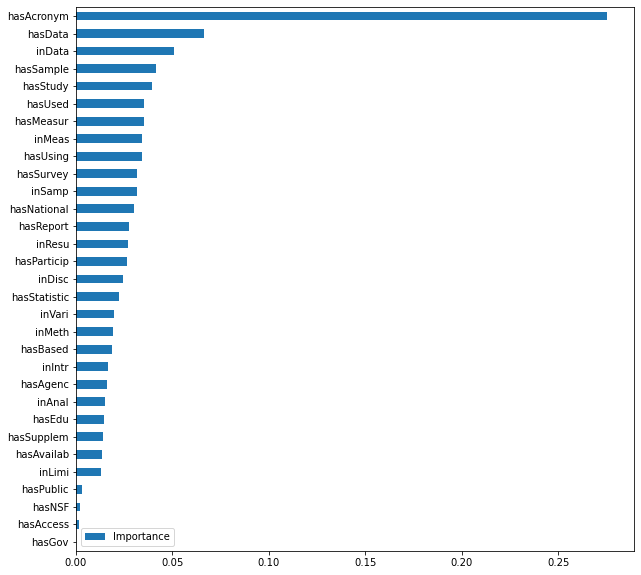

In [25]:
feats = {} 
for feature, importance in zip(X.columns, balanced_forests.named_steps["randomforestclassifier"].feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance').plot(kind='barh',figsize=(10,10))

Logistic Regression: 
"Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0."
(https://machinelearningmastery.com/calculate-feature-importance-with-python/)

<AxesSubplot:>

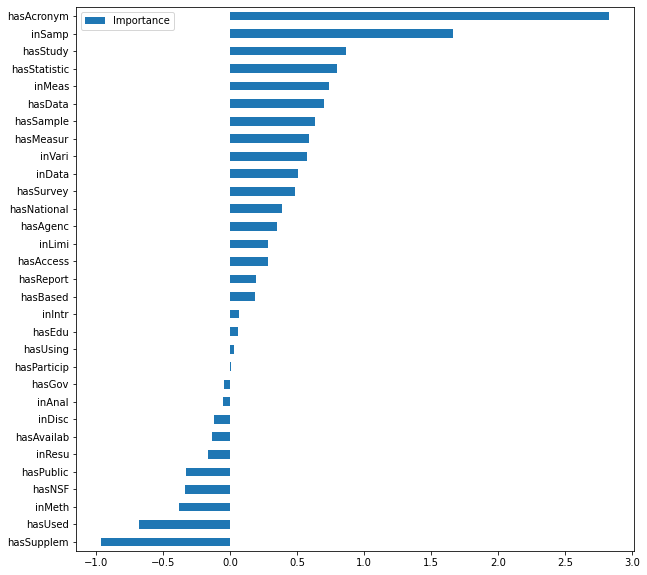

In [26]:
feats = {} 
for feature, importance in zip(X.columns, balanced_lr.named_steps["logisticregression"].coef_[0]):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance').plot(kind='barh',figsize=(10,10))

## Prediction probabilities
We can use cols `prob_0` and `prob_1` to filter sentences (as a way of guessing whether it is a citance)

In [27]:
prob = balanced_forests.predict_proba(X_test)
df_test = pd.DataFrame(X_test)
df_test['prob_0'] = prob[:,0] 
df_test['prob_1'] = prob[:,1]
df_test['Target'] = y_test

In [28]:
df_test

,hasData,hasEdu,hasSample,hasNational,hasSurvey,hasPublic,hasAvailab,hasNSF,hasGov,hasAccess,...,inMeth,inVari,inIntr,inLimi,inAnal,inResu,hasAcronym,prob_0,prob_1,Target
1949,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.217273,0.782727,True
132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.996497,0.003503,False
189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.988931,0.011069,False
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.963669,0.036331,False
20,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0.980759,0.019241,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.841236,0.158764,True
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.963669,0.036331,False
52,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0.970000,0.030000,False
2003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.277833,0.722167,True


## Save best model

In [29]:
# pkl_filename = "./output/model-RF.pkl"
pkl_filename = "./output/model-LR.pkl"

# with open(pkl_filename, 'wb') as file:
#     pickle.dump(balanced_forests, file)